# TP2

Elaborado por: Alan Churichi

In [1]:
%load_ext lab_black

import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import os

Implementar la función create_gauss_filter(h, w, k_size, sigma) para crear filtros gaussianos para filtrado 
espectral. Debe retornar un filtro gaussiano de tamaño HxW en dominio espacial y su transformada de Fourier.

1. Graficar ambas representaciones para diferentes tamaños de kernel y sigma. Aplicar el filtro una imagen para 
validar el funcionamiento en el dominio espectral.

2. Comparar el resultado de hacer un filtrado por convolución con el mismo kernel.

Definimos una función para cargar imágenes y la función para crear filtros gaussianos.

In [2]:
def load_image(path, filename, grayscale=False):
    flags = {"flags": cv.IMREAD_GRAYSCALE} if grayscale else {}
    img = cv.imread(os.path.join(path, filename), **flags)
    if grayscale:
        return img
    return cv.cvtColor(img, cv.COLOR_BGR2RGB)


def create_gauss_filter(h, w, k_size=15, sigma=5):
    canvas = np.zeros((h, w))
    kernel = cv.getGaussianKernel(k_size, sigma)
    kernel = kernel @ kernel.T
    start_y = h // 2 - kernel.shape[0] // 2
    start_x = w // 2 - kernel.shape[1] // 2
    canvas[
        start_y : start_y + kernel.shape[0],
        start_x : start_x + kernel.shape[1],
    ] = kernel
    return canvas, np.fft.fft2(canvas)

Probamos nuestra función generando un filtro con kernel de tamaño 5 y desviación estándar 5.
Luego graficamos el filtro y su transformada.

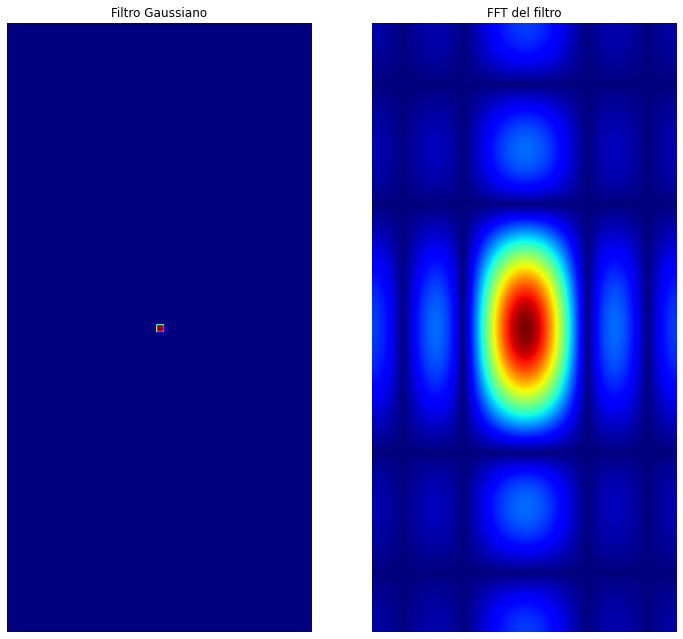

In [3]:
filter, filter_tf = create_gauss_filter(400, 200, k_size=5, sigma=5)

plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Filtro Gaussiano")
plt.imshow(filter, cmap="jet")
plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("FFT del filtro")
plt.imshow(np.abs(np.fft.fftshift(filter_tf)), cmap="jet")
plt.show()

A continuación cargamos la imagen 'fft_alfa_pred.png' en escala de grises y le aplicamos filtros gausianos generados distintos tamaños de kernel y desviación estándar.

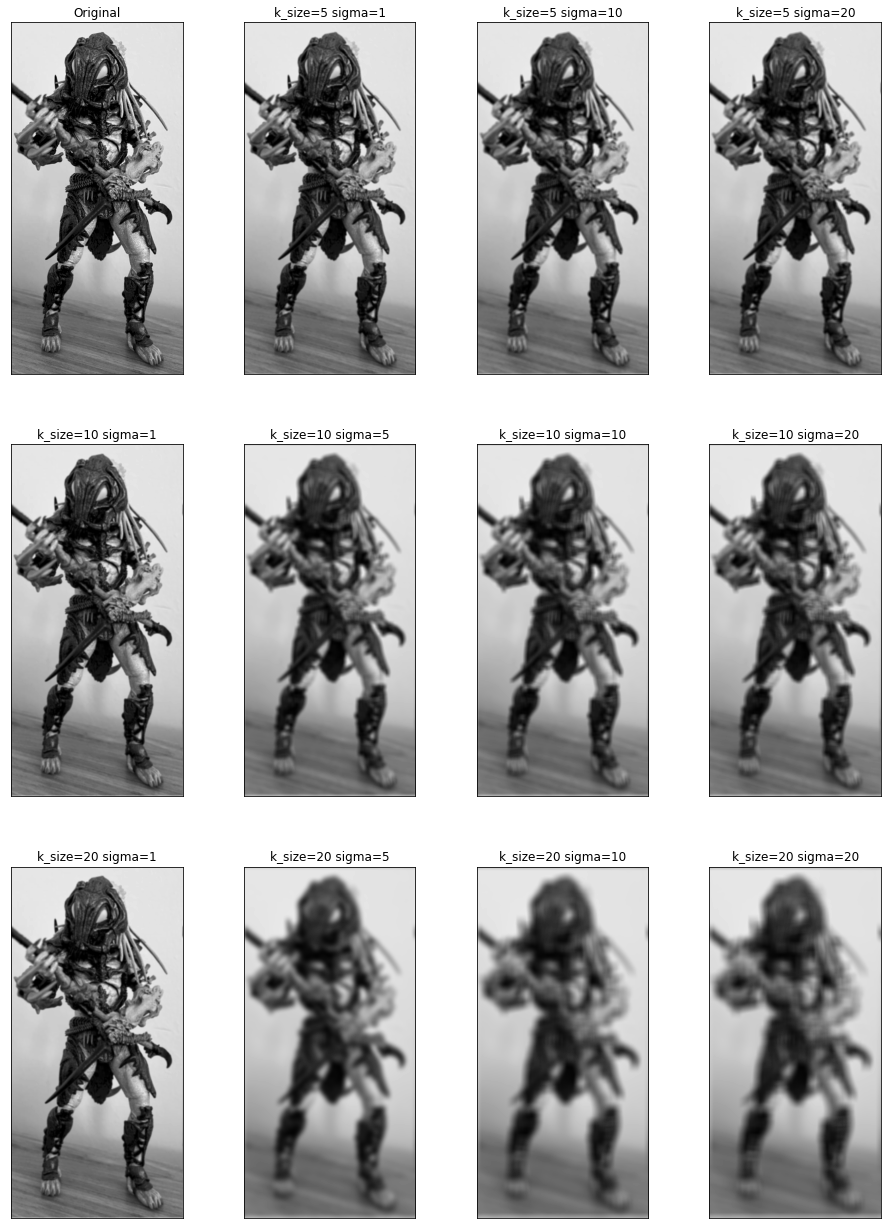

In [4]:
def filter_image(img, k_size, sigma):
    _, filter_tf = create_gauss_filter(
        img.shape[0],
        img.shape[1],
        k_size=k_size,
        sigma=sigma,
    )
    img_fft = np.fft.fft2(img)
    filtered = img_fft * filter_tf
    return np.fft.ifftshift(np.real(np.fft.ifft2(filtered)))


def plot_examples(img, filter_func, combinations, size, figsize=(16, 22)):
    _, axes = plt.subplots(size[0], size[1], figsize=figsize)
    for i in range(size[0]):
        for j in range(size[1]):
            if i == 0 and j == 0:
                processed_img = img
                title = "Original"
            else:
                (k_size, sigma) = combinations[(size[0] + 1) * i + j]
                processed_img = filter_func(img, k_size, sigma)
                title = f"k_size={k_size} sigma={sigma}"
            axes[i][j].imshow(processed_img, cmap="gray", vmin=0, vmax=255)
            axes[i][j].title.set_text(title)
            axes[i][j].xaxis.set_visible(False)
            axes[i][j].yaxis.set_visible(False)


images_path = "/tf/notebooks/CEIA/computer-vision-1/tp2/assets"

img = load_image(images_path, "fft_alfa_pred.png", grayscale=True)

combinations = [
    (None, None),
    (5, 1),
    (5, 10),
    (5, 20),
    (10, 1),
    (10, 5),
    (10, 10),
    (10, 20),
    (20, 1),
    (20, 5),
    (20, 10),
    (20, 20),
]

plot_examples(img, filter_image, combinations, size=(3, 4), figsize=(16, 22))

Como podemos ver al aumentar los valores del kernel y el valor de sigma aumenta el efecto de blur.

Observarnado detenidamente los distintos casos nos damos cuenta de que para aumentar el efecto ambos valores deben ser elevados. Si uno toma valores altos y el otro no el efecto conseguido es menor. También vemos que el tamaño de kernel influye mucho más en el efecto que el valor de desviación estándar.

Probamos realizar el filtrado mediante convolución entre la imagen y un kernel gaussiano con las mismas caractéristicas que los que se usaron en los casos anteriores.

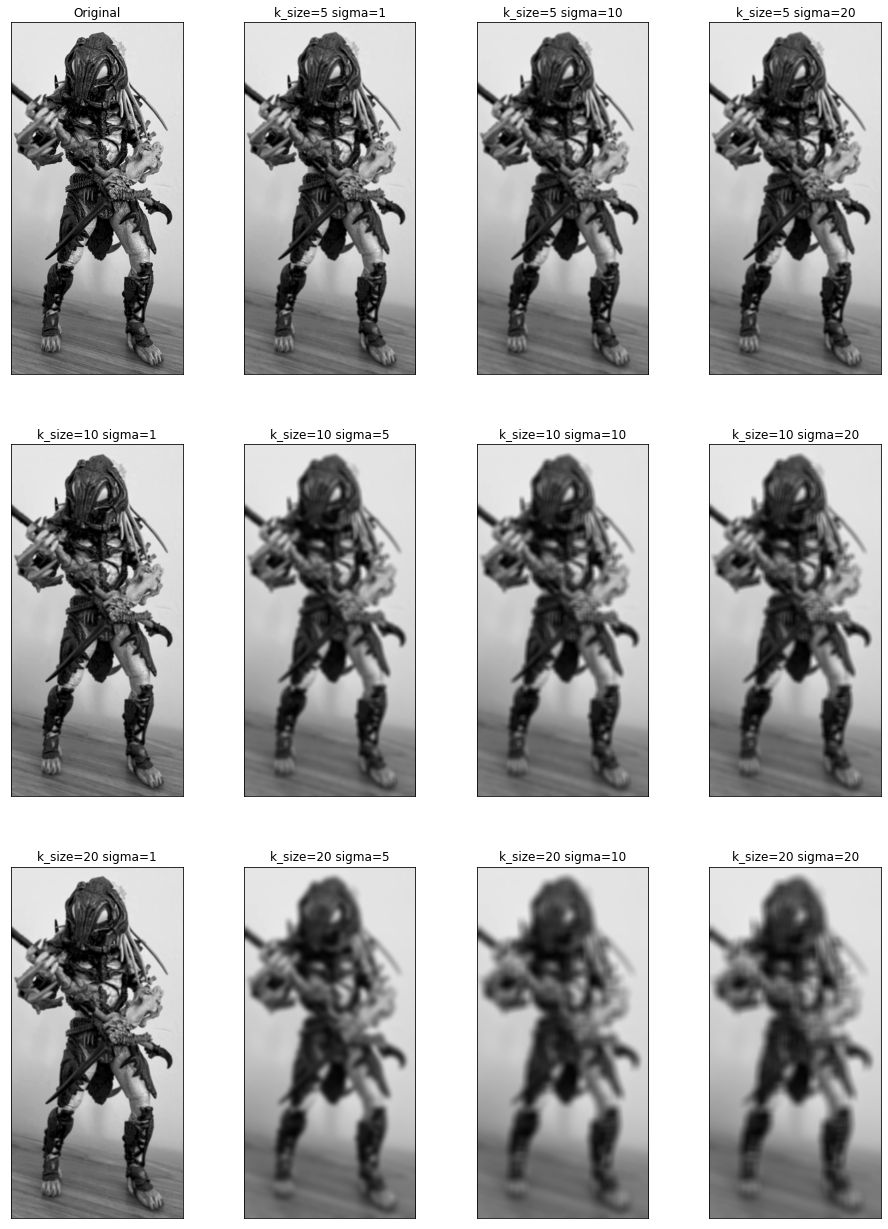

In [5]:
def filter_image_conv(img, k_size, sigma):
    kernel = cv.getGaussianKernel(k_size, sigma)
    kernel = kernel @ kernel.T
    return cv.filter2D(img, -1, kernel)


plot_examples(img, filter_image_conv, combinations, size=(3, 4), figsize=(16, 22))

Los resultados se ven iguales, lo cual tiene sentido ya que por propiedades de la Transformada de Fourier convolucionar en el dominio temporal es igual a multiplicar en el dominio frecuencial.

▪ Para la imagen suministrada “metal grid”. Implementar un algoritmo que:
1. Calcule los gradientes en la imagen (dirección y módulo)
2. Muestre imágenes de ángulo y módulo
3. Marque con colores las direcciones de gradientes más representativos.

Visualizamos la imagen 'metalgrid.jpg'.

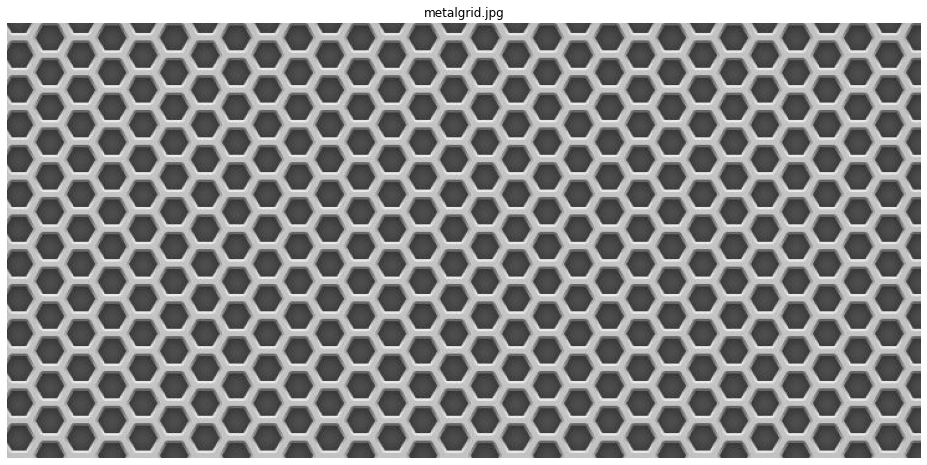

In [6]:
img = load_image(images_path, "metalgrid.jpg", grayscale=True)

plt.figure(figsize=(20, 8))
plt.imshow(img, cmap="gray", vmin=0, vmax=255)
plt.axis("off")
plt.title("metalgrid.jpg")
plt.show()

Se realiza un blur gaussiano y luego se calculan filtros de sobel para *x* y *y*. Utilizando estos se puede obtener la magnitud y dirección de los gradientes de la imagen.

In [7]:
blur = cv.GaussianBlur(img, (5, 5), 0)

sobel_x_64 = cv.Sobel(blur, cv.CV_32F, 1, 0, ksize=3)
abs_x_64 = np.absolute(sobel_x_64)
sobel_x_8u = np.uint8(abs_x_64 / abs_x_64.max() * 255)

sobel_y_64 = cv.Sobel(blur, cv.CV_32F, 0, 1, ksize=3)
abs_y_64 = np.absolute(sobel_y_64)
sobel_y_8u = np.uint8(abs_y_64 / abs_y_64.max() * 255)

mag = np.hypot(sobel_x_8u, sobel_y_8u)
mag = np.uint8(mag / mag.max() * 255)

theta = np.arctan2(sobel_y_64, sobel_x_64)
angle = np.rad2deg(theta)

Con los resultados obtenidos podemos graficar el módulo de la imágen.

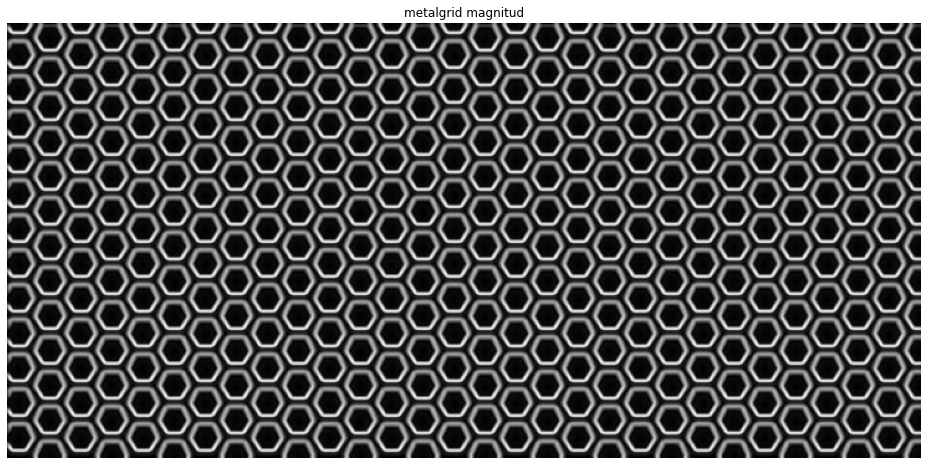

In [8]:
plt.figure(figsize=(20, 8))
plt.imshow(mag, cmap="gray", vmin=0, vmax=255)
plt.axis("off")
plt.title("metalgrid magnitud")
plt.show()

También se pueden graficar los ángulos de la imagen.

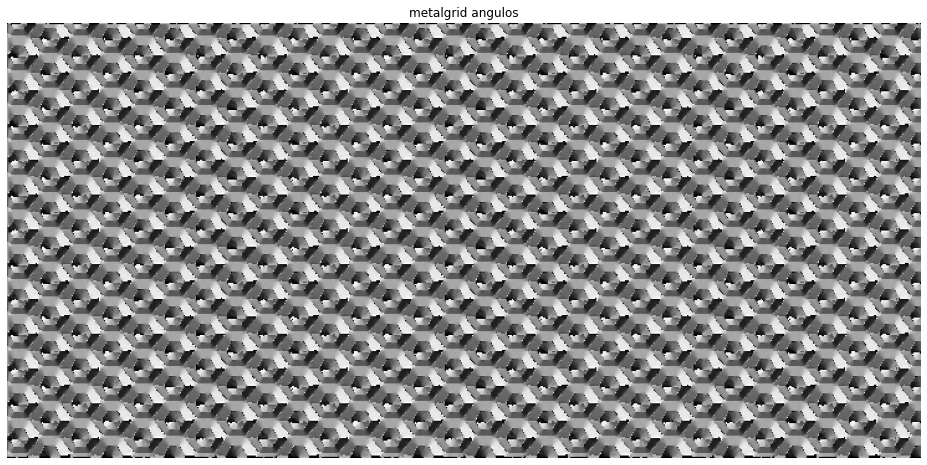

In [9]:
plt.figure(figsize=(20, 8))
plt.imshow(np.uint8(angle), cmap="gray", vmin=0, vmax=255)
plt.axis("off")
plt.title("metalgrid angulos")
plt.show()

Utilizando funciones lógicas y analizando los valores de ángulos y magnitud de la imagen, podemos separar los distintos gradientes con diferentes colores.

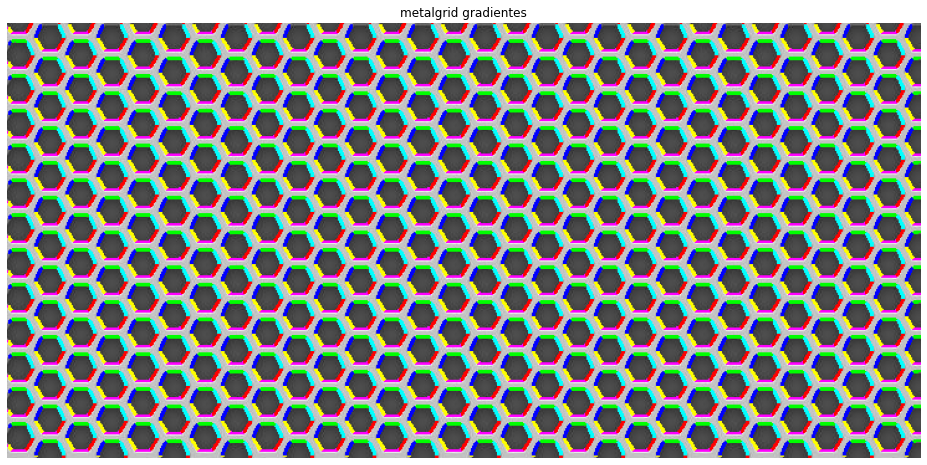

In [10]:
img_rgb = load_image(images_path, "metalgrid.jpg")

for i, angle_limit in enumerate(range(-180, 180, 60)):
    # Generamos un string binario y lo convertimos a un array de colores
    bin = np.binary_repr(i + 1).rjust(3, "0")
    color = [int(num) * 255 for num in bin]
    img_rgb[
        np.logical_and(
            (mag >= 120),
            np.logical_and(angle >= angle_limit, angle < (angle_limit + 60)),
        ),
    ] = color


plt.figure(figsize=(20, 8))
plt.imshow(img_rgb, vmin=0, vmax=255)
plt.axis("off")
plt.title("metalgrid gradientes")
plt.show()